In [2]:
##Import Statements:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA  # Import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import rand_score, adjusted_rand_score

The cell below is to be used for PCA on all of the following clustering algorithms:

In [3]:
# Load data
data = pd.read_csv('suicide.csv')

# Drop rows with missing 'Tweet'
data.dropna(subset=['Tweet'], inplace=True)

texts = data['Tweet'].tolist()

# Initialize VADER sentiment intensity analyzer
analyzer = SentimentIntensityAnalyzer()

# Get the VADER compound sentiment score for each tweet
data['sentiment_score'] = data['Tweet'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Feature extraction (Bag of Words)
count_vectorizer = CountVectorizer(max_features=1000, binary=True)
bow_matrix = count_vectorizer.fit_transform(data['Tweet'])

# Convert sparse matrix to dense matrix
bow_matrix_dense = bow_matrix.toarray()

# Standardize the features (important for k-means and PCA)
# scaler = StandardScaler()
# bow_matrix_dense = scaler.fit_transform(bow_matrix_dense)

# Combine Bag of Words matrix with sentiment scores
# Reshape sentiment scores to be added as a feature
sentiment_scores = data['sentiment_score'].values.reshape(-1, 1)
features_combined = np.hstack((bow_matrix_dense, sentiment_scores))

# print(features_combined)

# PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=42)  # Initialize PCA
pca_matrix = pca.fit_transform(bow_matrix_dense)  # Apply PCA transformation

## KMeans Clustering on PCA

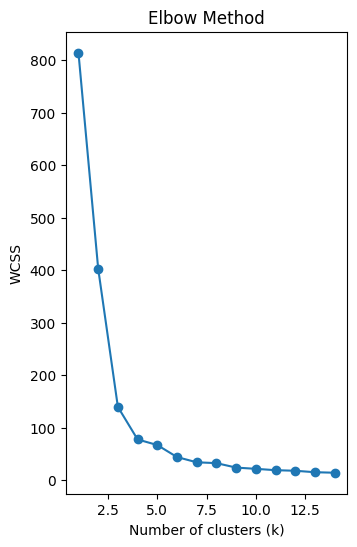

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


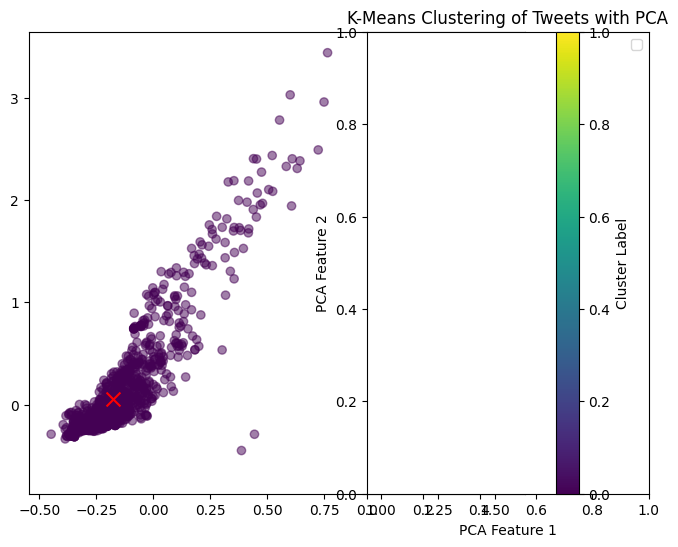

K-Means F1 Score: 0.9311377245508982
K-Means Rand : 0.6050382484832498
K-Means Adjusted Rand: 0.1793769407924069
Text: making lunch | Sentiment: Positive
Text: alexia want money | Sentiment: Positive
Text: dizzyhrvy crap took forever put together going go sleep days | Sentiment: Positive
Text: jnaylor kiwitweets hey jer since start twittering | Sentiment: Positive
Text: trying quot delicious library quot mixed results bar code thought wanted add sport bra instead drill cool app tho | Sentiment: Positive
Text: valenvaldez oh good hear already continue holy week | Sentiment: Positive
Text: got list fellow hotties gon na share one amigo | Sentiment: Positive
Text: jakepaul jamescharles loganpaul shane made series doesnt mean people take seriously https co | Sentiment: Negative
Text: time warsaw beer garden chilling | Sentiment: Positive
Text: hate life lmao hope die soon sumn tired everything | Sentiment: Positive
Text: everything lover survival everything mother survival | Sentiment: Pos

In [4]:
# Determine the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of square
for i in range(1, 15):  # Test a range of k values
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(pca_matrix)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(8, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, 15), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()

optimal_k = 2

# Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['cluster_label'] = kmeans.fit_predict(pca_matrix)



# Plotting
plt.figure(figsize=(8, 6))

# Scatter plot of the clusters
plt.scatter(pca_matrix[:, 0], pca_matrix[:, 1], c=data['cluster_label'], cmap='viridis', alpha=0.5)

# Plot centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='red', label='Centroids')

# Plot details
plt.subplot(1, 2, 2)
plt.title('K-Means Clustering of Tweets with PCA')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar(label='Cluster Label')
plt.legend()
plt.show()

labels = kmeans.labels_
sentiment_labels = ['Positive' if label == 0 else 'Negative' for label in labels]

#---------------------------
tweet_labels = data['Suicide'] 
true_labels = np.where(tweet_labels == 'Potential Suicide Post', 1, 0)

f1 = f1_score(true_labels, labels, average='weighted')
print("K-Means F1 Score:", f1)



kmeans_pred = pd.DataFrame()
kmeans_pred['true'] = tweet_labels
kmeans_pred['pred'] =  labels
kmeans_rand = rand_score(kmeans_pred['true'], kmeans_pred['pred'])
kmeans_adjusted_rand = adjusted_rand_score(kmeans_pred['true'], kmeans_pred['pred'])

print("K-Means Rand :", kmeans_rand)
print("K-Means Adjusted Rand:", kmeans_adjusted_rand)

#------------------------------

# Output sentiment labels for each text
for i, text in enumerate(texts):
    print(f"Text: {text} | Sentiment: {sentiment_labels[i]}")

# Define the filename for the output text file
output_file = "sentiment_labels.txt"

# Open the output file in write mode
with open(output_file, "w") as f:
    # Loop through each text and its corresponding sentiment label
    for text, sentiment_label in zip(texts, sentiment_labels):
        # Write the text and its sentiment label to the file
        print(f"Text: {text} | Sentiment: {sentiment_label}", file=f)

print("Sentiment labels exported to:", output_file)


## Gaussian Mixture Model on PCA

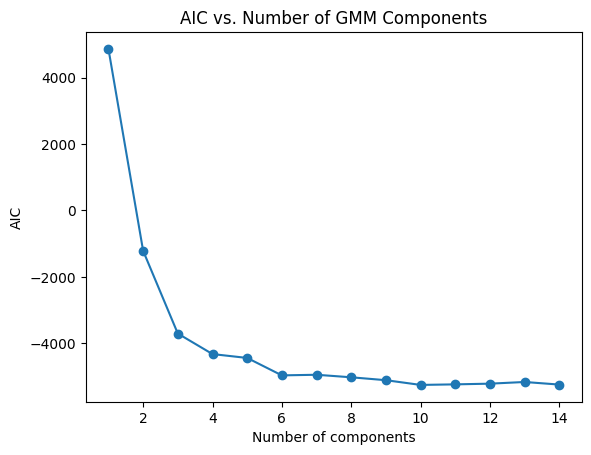

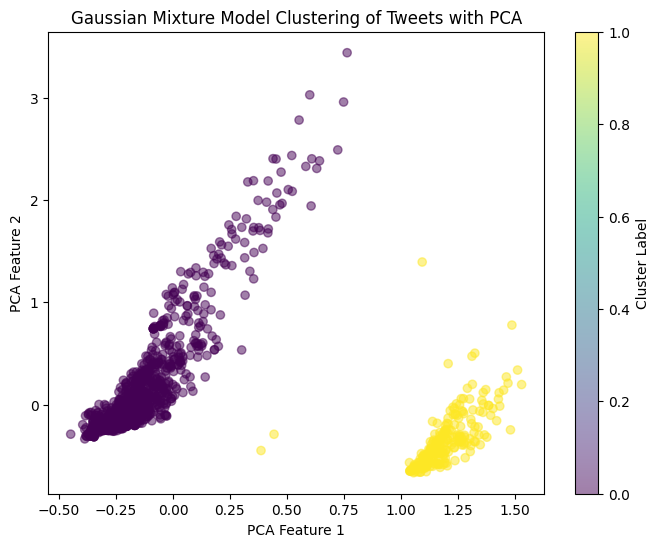

GMM F1 Score: 0.9304973037747154
GMM Rand : 0.6040120083908003
GMM Adjusted Rand: 0.177437612438209
Sentiment labels exported to: sentiment_labels2.txt


In [28]:

# Determine the optimal number of components using the Akaike information criterion (AIC)
n_components = np.arange(1, 15)
models = [GaussianMixture(n, random_state=42).fit(pca_matrix) for n in n_components]
plt.plot(n_components, [m.aic(pca_matrix) for m in models], marker='o')
plt.xlabel('Number of components')
plt.ylabel('AIC')
plt.title('AIC vs. Number of GMM Components')
plt.show()

# Choose the optimal number of components with the lowest AIC
optimal_n_components = np.argmin([m.aic(pca_matrix) for m in models]) + 1

# Clustering with Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=42)
data['cluster_label'] = gmm.fit_predict(pca_matrix)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(pca_matrix[:, 0], pca_matrix[:, 1], c=data['cluster_label'], cmap='viridis', alpha=0.5)
plt.title('Gaussian Mixture Model Clustering of Tweets with PCA')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Output sentiment labels for each text
labels = gmm.predict(pca_matrix)
sentiment_labels = ['Positive' if label == 0 else 'Negative' for label in labels]

#--F1-------F1-------F1-------
tweet_labels = data['Suicide'] 
true_labels = np.where(tweet_labels == 'Potential Suicide Post', 1, 0)

f1 = f1_score(true_labels, labels, average='weighted')
print("GMM F1 Score:", f1)


gmm_pred = pd.DataFrame()
gmm_pred['true'] = tweet_labels
gmm_pred['pred'] = gmm.predict(pca_matrix)
gmm_rand = rand_score(gmm_pred['true'], gmm_pred['pred'])
gmm_adjusted_rand = adjusted_rand_score(gmm_pred['true'], gmm_pred['pred'])
print("GMM Rand :", gmm_rand)
print("GMM Adjusted Rand:", gmm_adjusted_rand)
#--F1-------F1-------F1-------


# Export sentiment labels to a text file
output_file = "sentiment_labels2.txt"
with open(output_file, "w") as f:
    for text, sentiment_label in zip(texts, sentiment_labels):
        print(f"Text: {text} | Sentiment: {sentiment_label}", file=f)

print("Sentiment labels exported to:", output_file)

## DBSCAN on PCA

Best Silhouette Score: 0.7332091993849387
Best eps: 0.1
Best min_samples: 5


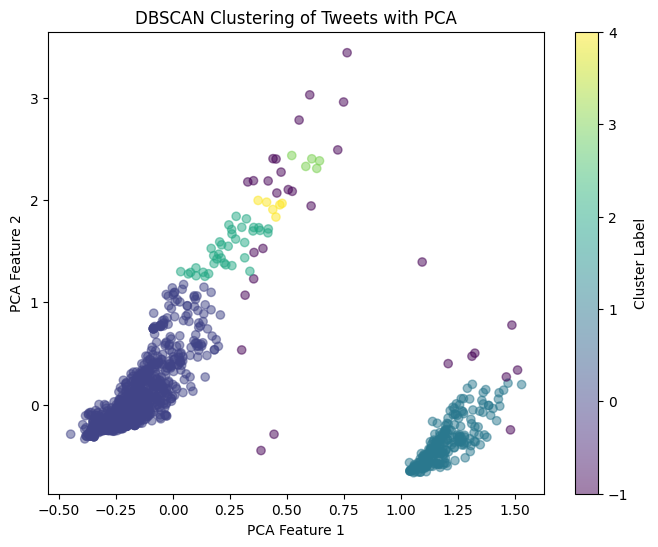

DBSCAN F1 Score: 0.908590645062672
GMM Rand : 0.632388740249463
GMM Adjusted Rand: 0.2432863426143979
Sentiment labels exported to: sentiment_labels_dbscan.txt


In [29]:
# Define range of eps and min_samples values to search over
eps_values = [0.1, 0.5, 1.0]
min_samples_values = [5, 10, 15]

best_score = -1
best_eps = None
best_min_samples = None
best_labels = None

# Perform grid search
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(pca_matrix)
        unique_labels = np.unique(labels)
        if len(unique_labels) > 1:  # Ensure more than one cluster
            score = silhouette_score(pca_matrix, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
                best_labels = labels

print("Best Silhouette Score:", best_score)
print("Best eps:", best_eps)
print("Best min_samples:", best_min_samples)

# Use the best parameters to perform DBSCAN clustering
dbscan = DBSCAN(eps=0.05, min_samples=2)
data['cluster_label'] = best_labels

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(pca_matrix[:, 0], pca_matrix[:, 1], c=data['cluster_label'], cmap='viridis', alpha=0.5)
plt.title('DBSCAN Clustering of Tweets with PCA')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Output sentiment labels for each text
labels = best_labels
sentiment_labels = ['Positive' if label == 0 else 'Negative' for label in labels]

#--F1-------F1-------F1-------
tweet_labels = data['Suicide'] 
true_labels = np.where(tweet_labels == 'Potential Suicide Post', 1, 0)

f1 = f1_score(true_labels, labels, average='weighted')
print("DBSCAN F1 Score:", f1)

db_pred = pd.DataFrame()
db_pred['true'] = tweet_labels
db_pred['pred'] = labels
db_rand = rand_score(db_pred['true'], db_pred['pred'])
db_adjusted_rand = adjusted_rand_score(db_pred['true'], db_pred['pred'])
print("DBSCAN Rand :", db_rand)
print("DBSCAN Adjusted Rand:", db_adjusted_rand)

#--F1-------F1-------F1-------

# Export sentiment labels to a text file
output_file = "sentiment_labels_dbscan.txt"
with open(output_file, "w") as f:
    for text, sentiment_label in zip(texts, sentiment_labels):
        print(f"Text: {text} | Sentiment: {sentiment_label}", file=f)

print("Sentiment labels exported to:", output_file)